In [1]:
#If CatBoost is not installed uncomment the code under this before running
#%conda install -c conda-forge catboost -y

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
import ast
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv("preprocessed-data.csv")

#Data Cleaning
df = df.dropna(subset=['metacritic_score'])
df['metacritic_score'] = pd.to_numeric(df['metacritic_score'], errors='coerce')
df_clean = df.dropna(subset=['metacritic_score'])

Plotting for Basic Visual Analysis

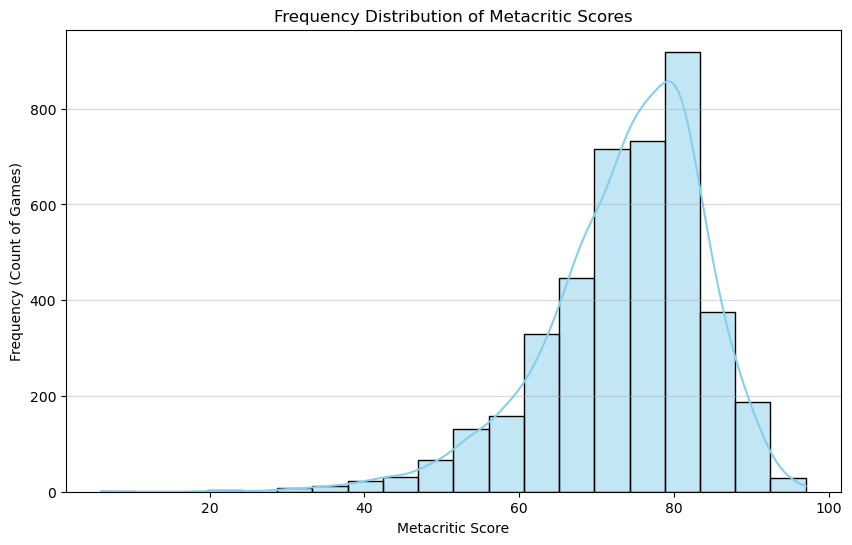

In [4]:
#Plotting frequency of Metacritic scores

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='metacritic_score',
    bins=20,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

plt.title('Frequency Distribution of Metacritic Scores')
plt.xlabel('Metacritic Score')
plt.ylabel('Frequency (Count of Games)')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [5]:
# Setting up the data to be plotted properly

# Convert the string representation of a list into a real list
def convert_to_list(item):
    if pd.isna(item):
        return item
    if isinstance(item, str):
        try:
            # ast.literal_eval is safe and converts the string '[12, 31]' to a list [12, 31]
            return ast.literal_eval(item)
        except (ValueError, SyntaxError):
            return item # Return original if conversion fails
    return item

df['genre_id_csv'] = df['genre_id_csv'].apply(convert_to_list)

# Explode the list column so information can be plotted properly
df_exploded = df.explode('genre_id_csv')

# Convert the individual IDs to strings to ensure they are treated as categories
df_exploded['genre_id_csv'] = df_exploded['genre_id_csv'].astype(str)

# Remove any rows where explosion might have resulted in a missing genre ID
df_plot = df_exploded.dropna(subset=['genre_id_csv'])


C:\Users\jwkil\AppData\Local\Temp\ipykernel_10960\3600575107.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


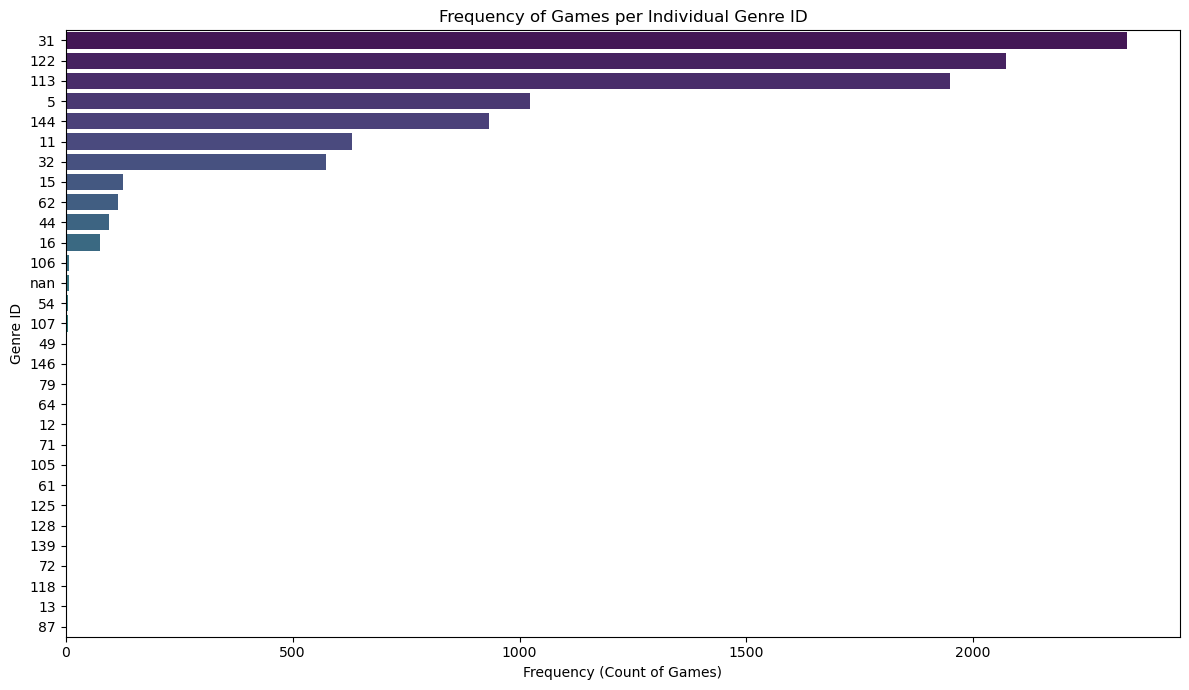

In [6]:
#Plotting Genres
plt.figure(figsize=(12, 7))
sns.countplot(
    data=df_plot, 
    y='genre_id_csv', 
    order=df_plot['genre_id_csv'].value_counts().index, # Sort by frequency
    palette='viridis' 
)

plt.title('Frequency of Games per Individual Genre ID')
plt.xlabel('Frequency (Count of Games)')
plt.ylabel('Genre ID')
plt.tight_layout()
plt.show()

C:\Users\jwkil\AppData\Local\Temp\ipykernel_10960\3625753446.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


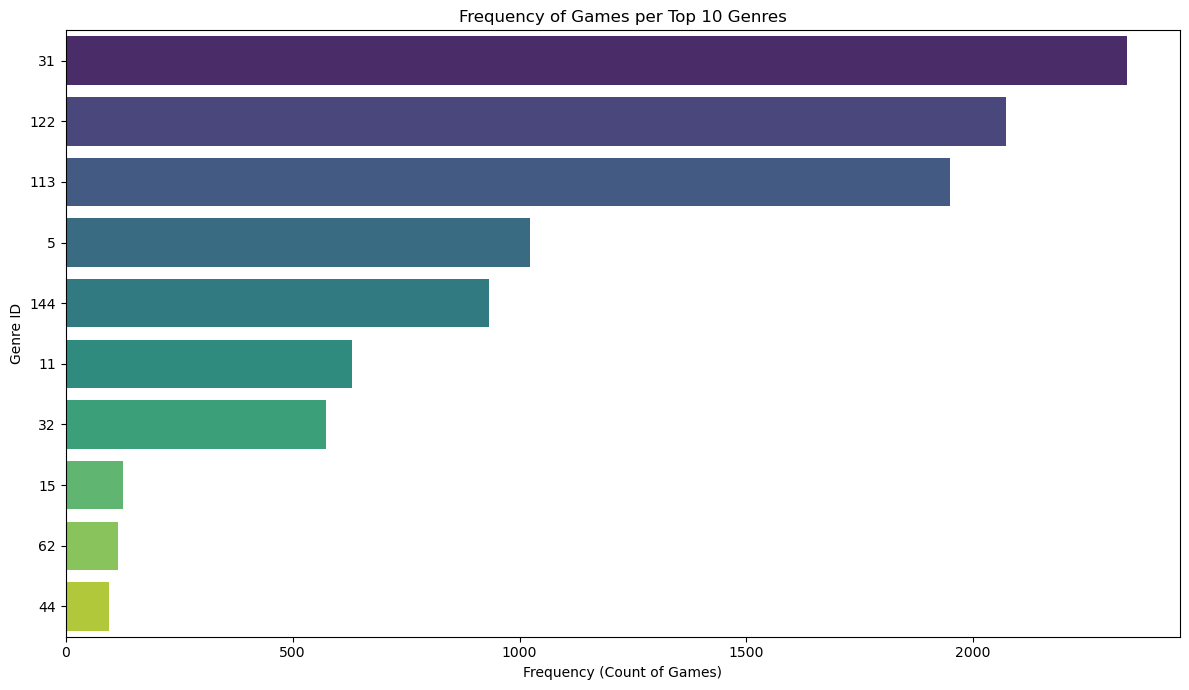

In [28]:

# Plot only the top 10 Genres

# Determine the top 10 genre IDs by count and filter the dataframe
top_10_genres = df_plot['genre_id_csv'].value_counts().nlargest(10).index
df_top_10 = df_plot[df_plot['genre_id_csv'].isin(top_10_genres)]

plt.figure(figsize=(12, 7))
sns.countplot(
    data=df_top_10, 
    y='genre_id_csv', 
    order=top_10_genres, # Use the predetermined top 20 order
    palette='viridis' 
)

plt.title('Frequency of Games per Top 10 Genres')
plt.xlabel('Frequency (Count of Games)')
plt.ylabel('Genre ID')
plt.tight_layout()
plt.show()

CatBoost Model 

In [8]:
# Multi-Hot Encoding for model training
genre_dummies = df['genre_id_csv'].str.get_dummies(sep=',')
df_encoded = pd.concat([df, genre_dummies], axis=1)
df_encoded = df_encoded.drop('genre_id_csv', axis=1)

In [9]:
# Convert genre_id_csv back from lists to strings so the model can be trained
df['genre_id_csv'] = df['genre_id_csv'].apply(
    lambda x: ','.join(map(str, x)) if isinstance(x, (list, tuple, pd.Series)) else x
)

# Convert NaN values in the categorical column to a string placeholder
df['genre_id_csv'] = df['genre_id_csv'].fillna('NONE')

# Ensure all remaining values are strings
df['genre_id_csv'] = df['genre_id_csv'].astype(str)
features = ['is_free', 'mat_supports_windows', 'mat_supports_mac', 'mat_supports_linux', 'mat_initial_price',
            'mat_final_price', 'mat_discount_percent' , 'genre_id_csv']
target = "metacritic_score"



In [10]:
#CatBoost Model Training
categorical_features_indices = ['genre_id_csv']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=100,         
    learning_rate=0.1,      
    depth=6,                
    loss_function='RMSE',   # Standard for regression
    verbose=0,              
    random_seed=42
)

model.fit(
    X_train, 
    y_train,
    cat_features=categorical_features_indices 
)

In [11]:
# Model Evaluation
y_pred = model.predict(X_test)
rmse = sklearn.metrics.root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(r2)

0.0709627924448808


In [12]:
#Feature Importance
feature_importance = model.get_feature_importance()

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by importance score
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance Scores:")
print(importance_df)



Feature Importance Scores:
                Feature  Importance
4     mat_initial_price   30.115399
7          genre_id_csv   24.980869
5       mat_final_price   24.040562
6  mat_discount_percent   19.655284
3    mat_supports_linux    0.764695
0               is_free    0.226654
2      mat_supports_mac    0.216537
1  mat_supports_windows    0.000000


C:\Users\jwkil\AppData\Local\Temp\ipykernel_10960\1295983199.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


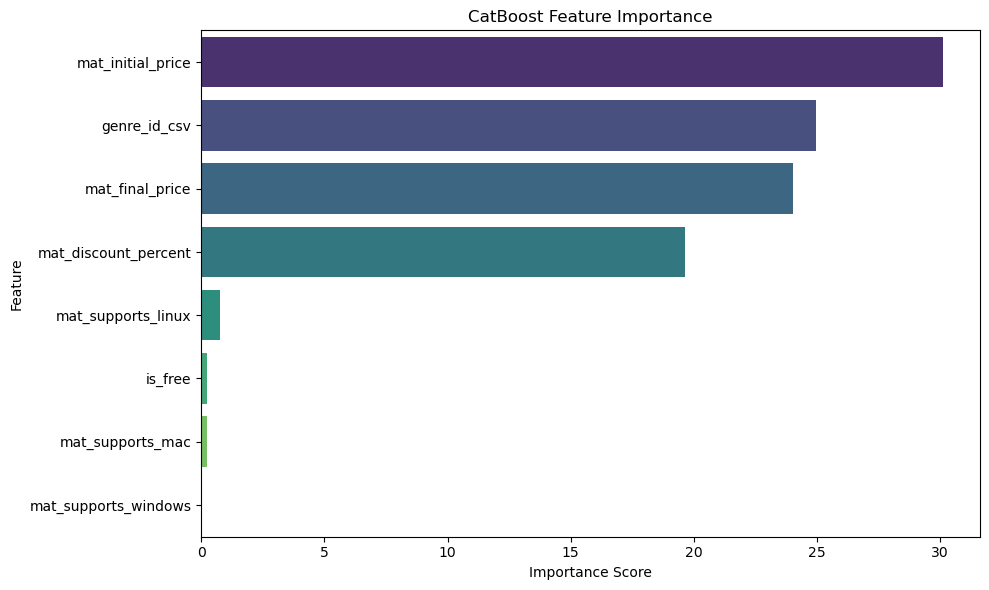

In [13]:
# Create a bar plot of feature importance
plt.figure(figsize=(10, 6))

sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

In [14]:

#Evaluating the model
def evaluate_regression_model(model, X_test, y_test):
    
    predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    # 4. Calculate the average Metacritic Score for context
    avg_score = y_test.mean()

    print(f"Test Set RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"Test Set MAE (Mean Absolute Error): {mae:.2f}")
    print(f"\nContext: Average Metacritic Score in Test Set: {avg_score:.2f}")

    print("\n--- Interpretation ---")
    print(f"On average, the model's predictions are off by approximately {mae:.2f} points.")
    print(f"If the typical score is around {avg_score:.2f}, an MAE of {mae:.2f} indicates the model's performance relative to the target scale.")

    return predictions, rmse, mae

In [15]:
# Plotting predicted values vs actual values
def plot_predictions_vs_actuals(predictions, y_test):
 
    y_actual = np.array(y_test)
    
    # plot aesthetics
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_actual, y=predictions, alpha=0.6, color='darkblue')

    # Add the ideal prediction line (y=x)
    min_val = min(y_actual.min(), predictions.min())
    max_val = max(y_actual.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Ideal Prediction (y=x)')

    plt.title('Actual vs. Predicted Metacritic Scores')
    plt.xlabel('Actual Metacritic Score')
    plt.ylabel('Predicted Metacritic Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Test Set RMSE (Root Mean Squared Error): 10.06
Test Set MAE (Mean Absolute Error): 7.68

Context: Average Metacritic Score in Test Set: 73.10

--- Interpretation ---
On average, the model's predictions are off by approximately 7.68 points.
If the typical score is around 73.10, an MAE of 7.68 indicates the model's performance relative to the target scale.


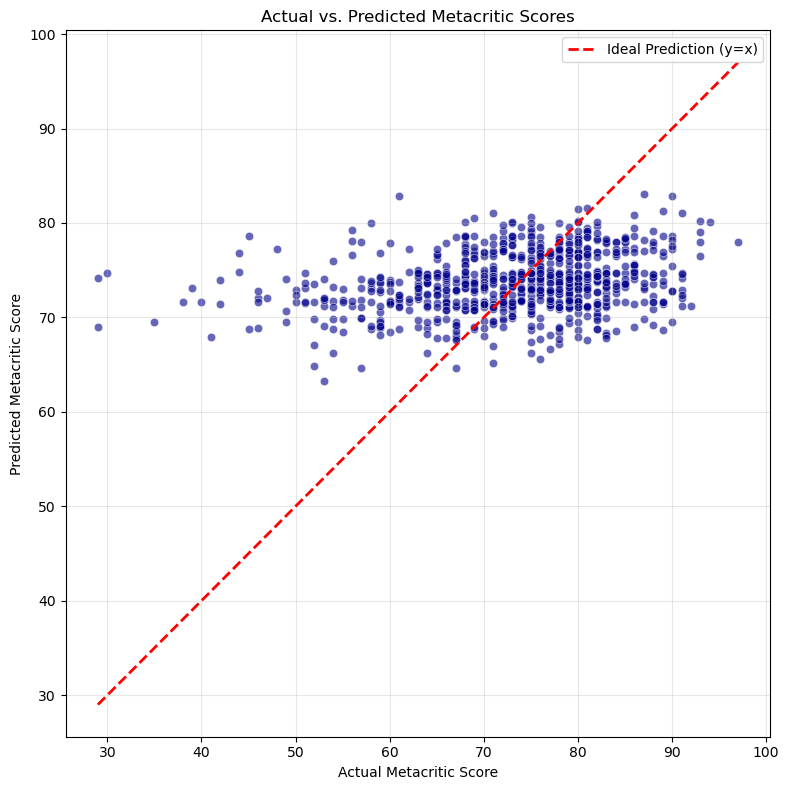

In [16]:
# Evaluate the model and print results 
predictions_result, rmse_result, mae_result = evaluate_regression_model(
    model, 
    X_test, 
    y_test
)

plot_predictions_vs_actuals(predictions_result, y_test)

Random Forest Model 

In [17]:
# Data Preparation for Random Forest
genre_dummies = df['genre_id_csv'].str.get_dummies(sep=',')
df_encoded = pd.concat([df.drop('genre_id_csv', axis=1), genre_dummies], axis=1)

initial_features = [
    'is_free', 'mat_supports_windows', 'mat_supports_mac', 'mat_supports_linux',
    'mat_initial_price', 'mat_final_price', 'mat_discount_percent'
]

# Get all dynamically created genre columns
genre_features = list(genre_dummies.columns)

all_features = initial_features + genre_features
target = "metacritic_score"

X = df_encoded[all_features]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Initialize and Train Random Forest Regressor

rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [19]:
# Evaluation
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)

print("\nRandom Forest Evaluation:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")


Random Forest Evaluation:
RMSE: 10.10
MAE: 7.75


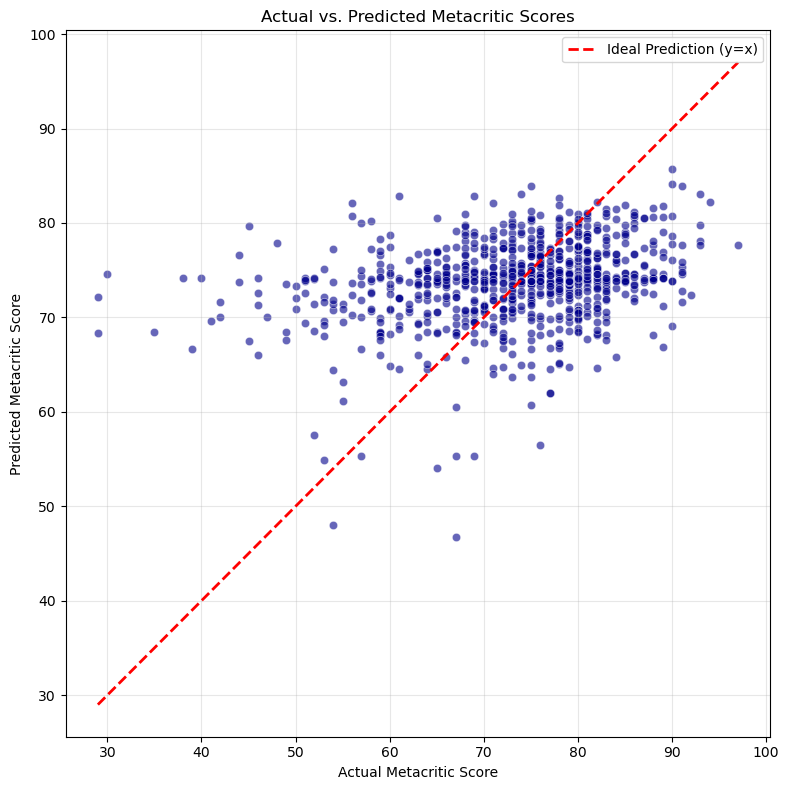

In [20]:
#Plotting predictions vs actual for Random Forest Model
plot_predictions_vs_actuals(rf_predictions, y_test)

In [21]:
# Feature Importance Calculation

importance_scores = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_scores
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nRandom Forest Feature Importance:")
print(importance_df)



Random Forest Feature Importance:
                 Feature  Importance
0      mat_initial_price    0.334116
1        mat_final_price    0.150184
2   mat_discount_percent    0.066995
3                    122    0.059491
4                     31    0.054924
5                    113    0.053488
6                      5    0.047020
7                     11    0.046386
8                     15    0.042949
9                    144    0.042559
10                    32    0.042472
11                    62    0.021590
12                    44    0.006799
13               is_free    0.005934
14                   106    0.005451
15                    16    0.004649
16    mat_supports_linux    0.003524
17                   107    0.002806
18                  NONE    0.002048
19                    49    0.001738
20                   139    0.001278
21                   146    0.001036
22                   105    0.000938
23      mat_supports_mac    0.000649
24                    79    0.000242
25 

C:\Users\jwkil\AppData\Local\Temp\ipykernel_10960\2531618241.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Reds_d')


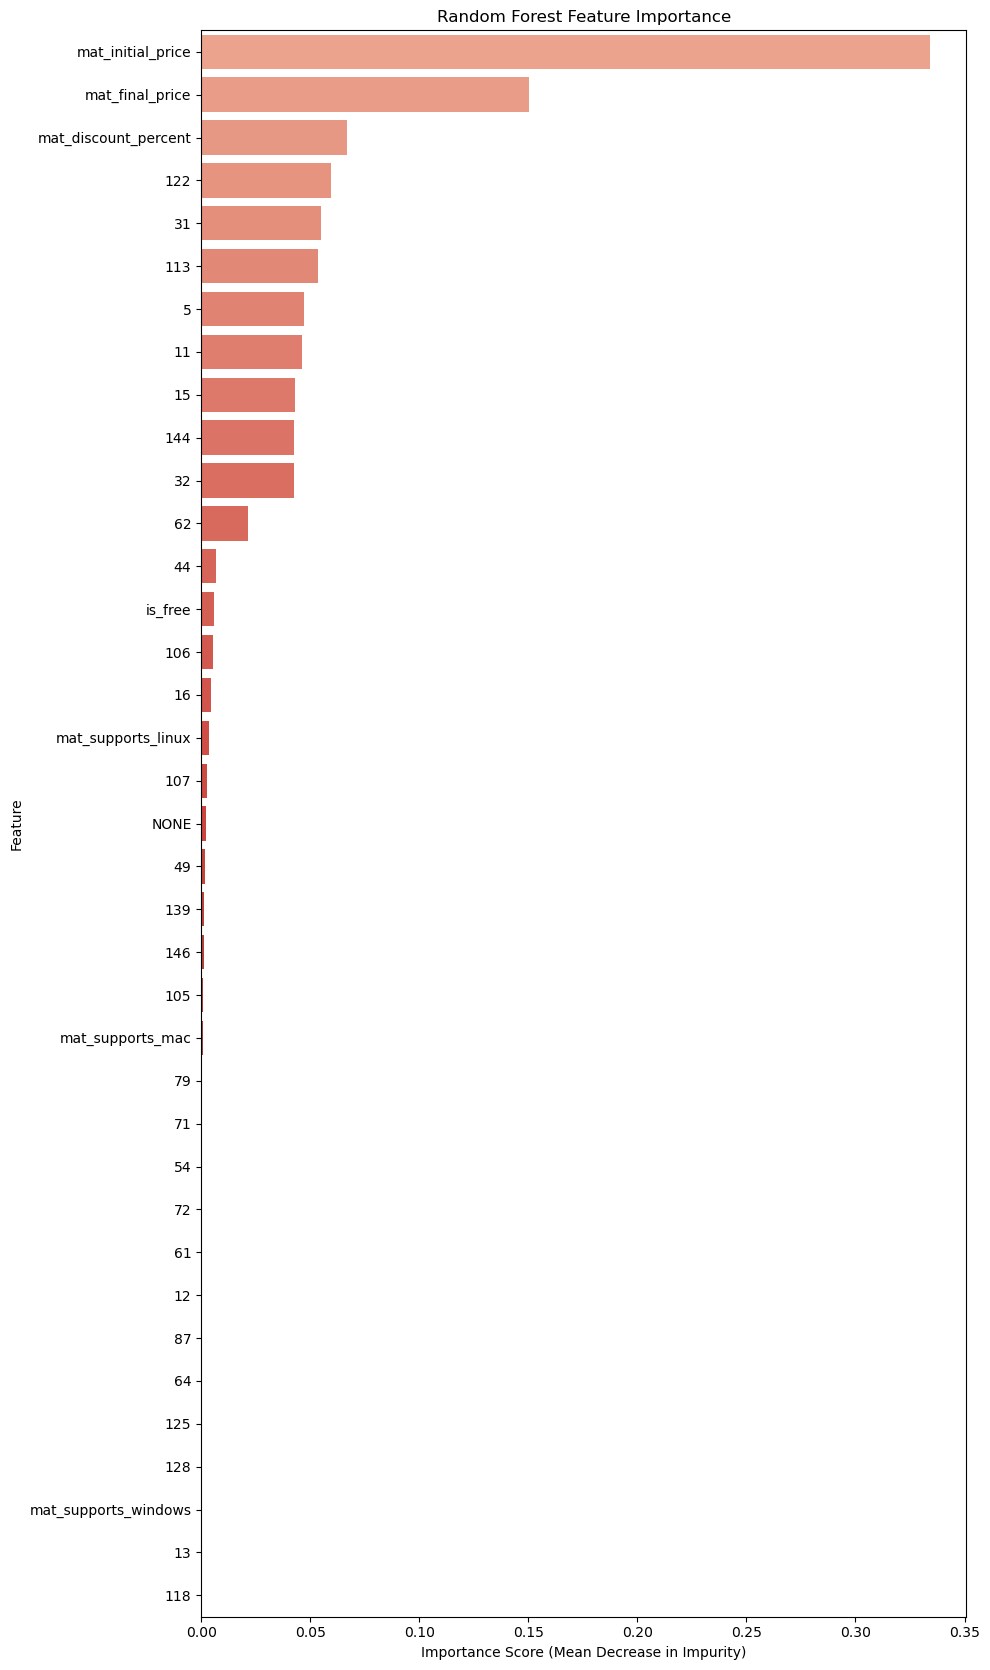

In [22]:
# Plot Feature importance for Random Forest Model
plt.figure(figsize=(10, len(all_features) * 0.4 + 2)) # Adjust figure size dynamically
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Reds_d')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score (Mean Decrease in Impurity)')
plt.ylabel('Feature')
plt.tight_layout()